# Forecast Stock Price using RDP Historical Pricing with Facebook Prophet library

## Introduction

First of all, let me introduce you to the [Refinitiv Data Platform(RDP)](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis), which provides simple web-based API access to a broad range of content provided by Refinitiv. It can retrieve data such as News, ESG, Symbology, Streaming Price, and Historical Pricing. And more content and services will be added to the platform in the future. To access the content, developers can use any programming language that provides the REST client library to call the REST interfaces and get data from RDP services. To help API users access RDP content easier, we provide the Refinitiv Data Platform (RDP) Libraries that provide a set of uniform interfaces providing the developer access to the Refinitiv Data Platform. We are currently providing an RDP Library for Python, .NET, and Typescript/Javascript, which will be released soon. Developers and data scientists can leverage the library's functionality to retrieve data from the RDP services. Basically, the original response message from the RDP service will be in JSON tabular format. Still, the RDP Library for Python will help you convert the JSON tabular format to the dataframe, so the user does not need to handle a JSON message and convert it manually. The data from RDP cover a wide range of the universe. Using RDP interfaces, developers can benefit from the services to retrieve only data for a specific period they want with Adjustments Behavior they need.

This article will show you the step to use RDP Library for Python to retrieve daily intraday pricing from RDP Historical Pricing service and then use the 3rd party library to forecast the data's stock price. To make it more simple to demonstrate the usage, in this article, I will apply the data with a Prophet library created by Facebook to forecast the price. Time-series forecasting is one of the hot topics with many possible applications, such as stock prices forecasting, weather forecasting, network resources allocation, and many others. Refinitiv provides the platform for users to automatically retrieving the dataset that contains a series of timestamps with the data, such as the stock price. You can then pass it to your own library or automatically use a 3rd party library to forecast and generate a chart in a few seconds.

[The prophet](https://facebook.github.io/prophet/) is open-source software released by Facebook’s Core Data Science team based on decomposable (trend+seasonality+holidays) models. It provides us with the ability to make time-series predictions with good accuracy using simple, intuitive parameters and has support for including the impact of custom seasonality and holidays. You can get a reasonable forecast on messy data with no manual effort. The prophet is robust to outliers, missing data, and dramatic changes in your time series according to the information on [the prophet page](https://facebook.github.io/prophet).

I will provide a Jupyter notebook with steps to call RDP Library and prepare data for use with the Prophet library to forecast the price and then shows the forecasting Chart for a final result.

## Prerequisites

* Follow instructions from [Quick Start Guide](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/quick-start) to install RDP Library for python.

    ```bash
    > pip install refinitiv.dataplatform
    ```

* Follow instructions from [Prophet Quick Start page](https://facebook.github.io/prophet/docs/quick_start.html#python-api) to install prophet library for python. Conda users may follow the following steps to install the Prophet.

  Install Ephem:

   ```bash
    conda install -c anaconda ephem
   ```

   Install Pystan library:

   ```bash
    conda install -c conda-forge pystan
   ```

   Finally, install Fbprophet

   ```bash
    conda install -c conda-forge fbprophet
   ```

* Ensure that you have the following additional python libraries.

  ```bash
  pyplots, matplotlib
  ```

* You must have RDP Account with permission to request data using Historical Pricing API. You can also login to [APIDocs page](https://apidocs.refinitiv.com/Apps/ApiDocs). Then you can search for the Historical Pricing and looking at section Reference for the document.
![apidocs](./images/apidocs_info.png)



## Getting Started using RDP API for python

I will create a configuration file to keep the RDP user info and read it using ConfigParser. This module provides a class that implements a basic configuration language that provides a structure similar to what’s found in Microsoft Windows INI files. We will start creating a configuration file name rdp_cofig.cfg. It will contain the rdpuser section, which use to keep app_key, username, and password.

Below is a sample configuration file you must create.

```bash
[rdpuser]
app_key =  <Appkey/ClientId>
username = <RDP User>
password = <RDP Password>
```

### Open Platform Session

Next step, we will import refinitiv.dataplatform library and pass RDP user to function open_platform_session to open a session to the RDP server. RDP library will handle the authorization and manage the session for you.

In [2]:
import refinitiv.dataplatform as rdp
import configparser as cp

cfg = cp.ConfigParser()
cfg.read('./rdp_config.cfg')
print(f"RDP Version {rdp.__version__}")

# Open RDP Platform Session
print("Open Platform Session")
session = rdp.open_platform_session(cfg['rdpuser']['app_key'],rdp.GrantPassword(username = cfg['rdpuser']['username'],password = cfg['rdpuser']['password']))

print(f"RDP Sesssion State is now {session.get_open_state()}")

RDP Version 1.0.0a7
Open Platform Session
RDP Sesssion State is now State.Open



### Retreive Time Series data from RDP

After the session state is Open, we will use the below get_historical_price_summaries interface to retrieve time series pricing Interday summaries data(i.e., bar data).

```python
get_historical_price_summaries(universe, interval=None, start=None, end=None, adjustments=None, sessions=[], count=1, fields=[], on_response=None, closure=None)
```

Actually, the implementation of this function will send HTTP GET requests to the following RDP endpoint.

```python
https://api.refinitiv.com/data/historical-pricing/v1/views/interday-summaries/
```

And the following details are possible values for interval and adjustment arguments.

Supported __intervals__:
Intervals.DAILY, Intervals.WEEKLY, Intervals.MONTHLY, Intervals.QUARTERLY, Intervals.YEARLY.

Supported value for __adjustments__:
'unadjusted', 'exchangeCorrection', 'manualCorrection', 'CCH', 'CRE', 'RPO', 'RTS', 'qualifiers'

You can pass an array of these values to the function like the below sample codes.

```python
adjustments=['unadjusted']
adjustments=['unadjusted','CCH','CRE','RPO','RTS']
```

Please find below details regarding the adjustments behavior; it's the details from a reference section on the APIDocs page. Note that it can be changed in future releases. I would suggest you leave it to the default value.

The adjustments are a query parameter that tells the system whether to apply or not apply CORAX (Corporate Actions) events or exchange/manual corrections or price and volume adjustment according to trade/quote qualifier summarization actions to historical time series data.

Normally, the back-end should strictly serve what clients need. However, if the back-end cannot support them, the back-end can still return the form that the back-end supports with the proper adjustments in the response and status block (if applicable) instead of an error message.

Limitations: Adjustment behaviors listed in the limitation section may be changed or improved in the future.

1. If any combination of correction types is specified (i.e., exchangeCorrection or manualCorrection), all correction types will be applied to data in applicable event types.

2. If any combination of CORAX is specified (i.e., CCH, CRE, RPO, and RTS), all CORAX will be applied to data in applicable event types.

Adjustments values for Interday-summaries and Intraday-summaries API

If unspecified, each back-end service will be controlled with the proper adjustments in the response so that the clients know which adjustment types are applied by default. In this case, the returned data will be applied with exchange and manual corrections and applied with CORAX adjustments.

If specified, the clients want to get some specific adjustment types applied or even unadjusted.

The supported values of adjustments:

* exchangeCorrection - Apply exchange correction adjustment to historical pricing
* manualCorrection - Apply manual correction adjustment to historical pricing, i.e., annotations made by content analysts
* CCH - Apply Capital Change adjustment to historical Pricing due to Corporate Actions, e.g., stock split
* CRE - Apply Currency Redenomination adjustment when there is redenomination of the currency
* RTS - Apply Reuters TimeSeries adjustment to adjust both historical price and volume
* RPO - Apply Reuters Price Only adjustment to adjust historical price only, not volume
* unadjusted - Not apply both exchange/manual correct and CORAX

Notes:

1. Summaries data will always have exchangeCorrection and manualCorrection applied. If the request is explicitly asked for uncorrected data, a status block will be returned along with the corrected data saying, "Uncorrected summaries are currently not supported".

2. unadjusted will be ignored when other values are specified.

Below is a sample code to retrieve Daily historical pricing for Facebook RIC FB.O, and I will set the start date from 2013 to 2020. You need to set the interval to rdp.Intervals.DAILY to get DAILY data.

In [3]:
import pandas as pd
import asyncio
from IPython.display import clear_output
data = rdp.get_historical_price_summaries(
    universe = 'FB.O',
    interval = rdp.Intervals.DAILY,          # Supported intervals: DAILY, WEEKLY, MONTHLY, QUARTERLY, YEARLY.
    start='2013.01.01', end='2020.11.10'
)
if data is not None:
    display(data.head())
    display(data.tail())
else:
    print("Error while process the data")

,TRDPRC_1,HIGH_1,LOW_1,ACVOL_UNS,OPEN_PRC,BID,ASK,TRNOVR_UNS,VWAP,BLKCOUNT,BLKVOLUM,NUM_MOVES,TRD_STATUS,SALTIM,NAVALUE
2012-12-31,26.6197,26.99,26.11,60374424,26.20,26.62,26.63,NaN,26.5285,341,6836672,180237,<NA>,<NA>,None
2013-01-02,28.0000,28.18,27.42,69844980,27.44,27.99,28.00,NaN,27.8649,315,8518197,194320,<NA>,<NA>,None
2013-01-03,27.7700,28.47,27.59,63140530,27.88,27.76,27.77,NaN,28.0130,369,7250462,181016,<NA>,<NA>,None
2013-01-04,28.7600,28.93,27.83,72715349,28.01,28.75,28.76,NaN,28.4672,406,8315298,197398,<NA>,<NA>,None
2013-01-07,29.4213,29.79,28.65,83781725,28.69,29.42,29.43,NaN,29.3918,362,7773412,239301,<NA>,<NA>,None


,TRDPRC_1,HIGH_1,LOW_1,ACVOL_UNS,OPEN_PRC,BID,ASK,TRNOVR_UNS,VWAP,BLKCOUNT,BLKVOLUM,NUM_MOVES,TRD_STATUS,SALTIM,NAVALUE
2020-11-03,265.30,270.05,260.88,17961859,263.1600,265.08,265.23,4.786779e+09,266.5869,21,1939803,193482,1,75600,None
2020-11-04,287.38,288.94,278.62,35364424,281.0000,287.32,287.45,1.008068e+10,285.2703,64,4375931,392413,1,75600,None
2020-11-05,294.68,297.38,288.95,23823633,291.8965,294.66,294.77,7.016663e+09,294.5037,27,3650966,254980,1,75600,None
2020-11-06,293.41,294.60,288.06,13890974,293.9500,293.40,293.41,4.061364e+09,292.3425,24,2206518,160420,1,75600,None
2020-11-09,278.77,292.58,278.53,25117650,289.8700,278.54,278.66,7.179238e+09,286.0423,31,3062551,308120,1,75600,None


### Prepare data for Prophet library

The Prophet follows the sklearn model API. We need to create an instance of the Prophet class and then call its fit and predict methods.

The Prophet's input is always a dataframe with two columns: __ds__ and __y__. The ds (datestamp or DateTime) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric and represents the measurement we wish to forecast.

Based on the result I show you previously, we already have an index which is a date stamp and also has a TRDPRC_1 column, which is trade price in a numeric format, so what we need to do is to re-create the data frame to a new one which contains columns ds and y. I will set the index name to "Date" and then call the reset_index function to add a new index and shift the datestamp to the Date column. Then I will rename the column to ds and y accordingly. Below is my sample codes.


In [4]:
data.index.name="Date"
df=data.reset_index(level=0)
# Select only the important features i.e. the date and price
df = df[["Date","TRDPRC_1"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
df = df.rename(columns = {"Date":"ds","TRDPRC_1":"y"}) #renaming the columns of the dataset
display(df)

,ds,y
0,2012-12-31,26.6197
1,2013-01-02,28.0000
2,2013-01-03,27.7700
3,2013-01-04,28.7600
4,2013-01-07,29.4213
...,...,...
1975,2020-11-03,265.3000
1976,2020-11-04,287.3800
1977,2020-11-05,294.6800
1978,2020-11-06,293.4100


You can also explore statistical data such as means of the trade price from the data frame by calling the describe() function.

In [5]:
df.describe()

,y
count,1980.000000
mean,129.138562
std,62.216891
min,22.899000
25%,77.162500
50%,128.025000
75%,177.895000
max,303.910000


### Create Prophet instance and fitting model

Next steps, we fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor. Then you call its fit method and pass in the historical dataframe. Fitting should take 1-5 seconds.

In [6]:
from fbprophet import Prophet
m = Prophet(daily_seasonality=False, yearly_seasonality=True) # the Prophet class (model)
m.fit(df) # fit the model using all data

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


### Set number of the day in the future and call predict

After we fitted the model using the data, we need to set the number of days we need to predict. Then we can call the predict function to forecast the data. Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe. By default, it will also include the dates from history to see the model fit.

In [7]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
forecast = m.predict(future)

When you call predict function, it will assign each row in the future a predicted value which it names yhat. If you pass on historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast and columns for components and uncertainty intervals. Let see the data by calling the tail() method from the forecast.

In [8]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2340,2021-11-05,308.118556,283.566127,333.385243
2341,2021-11-06,308.063897,284.222923,335.008522
2342,2021-11-07,307.843346,284.547044,333.333226
2343,2021-11-08,307.223919,283.535149,332.444994
2344,2021-11-09,307.173566,286.049627,332.369113


Next step, we will call the plot function provided by Prophet to visualize the data. Note that it requires the plotly lib to plot the Chart, so please ensure that you have the plotly lib installed before running the codes.

<IPython.core.display.Javascript object>


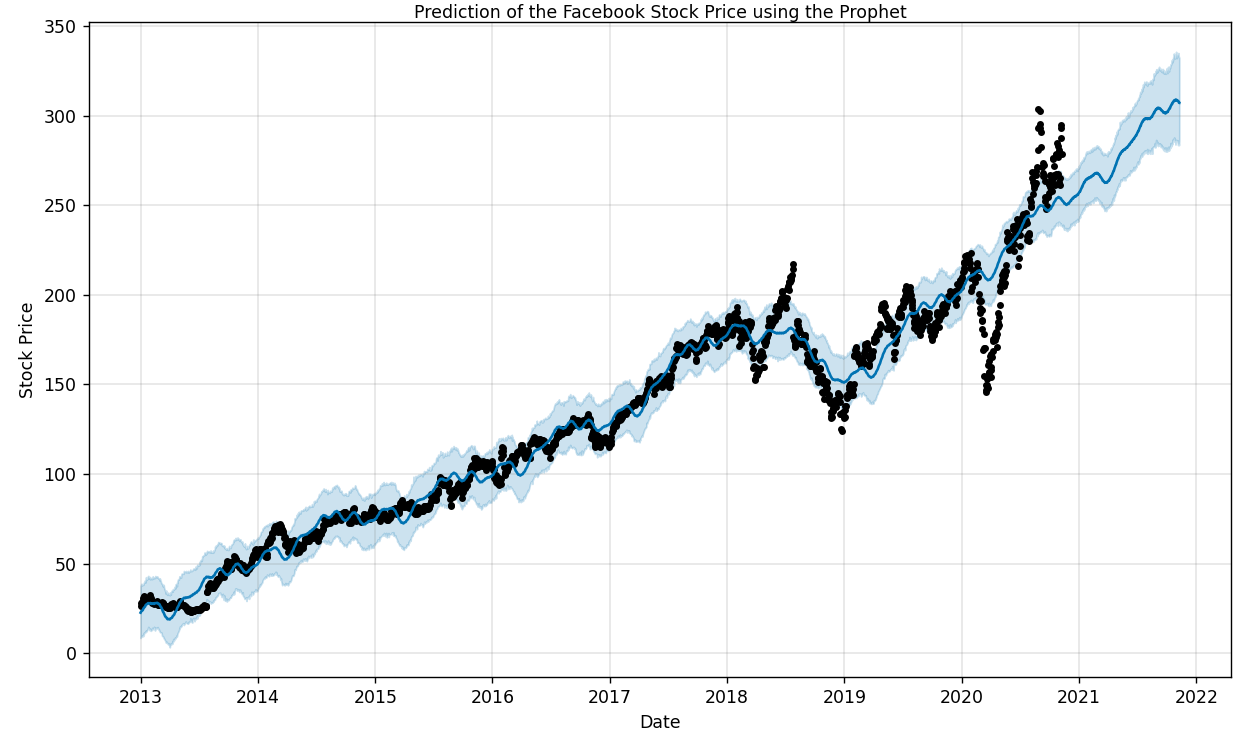

In [9]:
# importing module  
import matplotlib.pyplot as plt  
%matplotlib notebook
m.plot(forecast)
plt.title("Prediction of the Facebook Stock Price using the Prophet",fontsize=10,pad=1)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

The model used all the data for the training (black dots) and predicted the future stock price from the start to the end period specified in the function. You can find additional configuration and parameters to tweak the result from the [Prophet website](https://facebook.github.io/prophet/docs/quick_start.html#python-api).

The above picture is the chart for the next 365 days prediction period specified in the __make_future_dataframe__ method. The chart also provides the __Confidence Intervals (CI)__ in a Blue shadow, which is quite useful in statistics.

If you want to see the forecast components, you can use the Prophet.plot_components method. By default, you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

In our example, we show only the trend, the weekly and yearly performance of the stock based on our data. We will call plot_components from the instance of fbprophet to plot component chart as below snippet of codes.

<IPython.core.display.Javascript object>


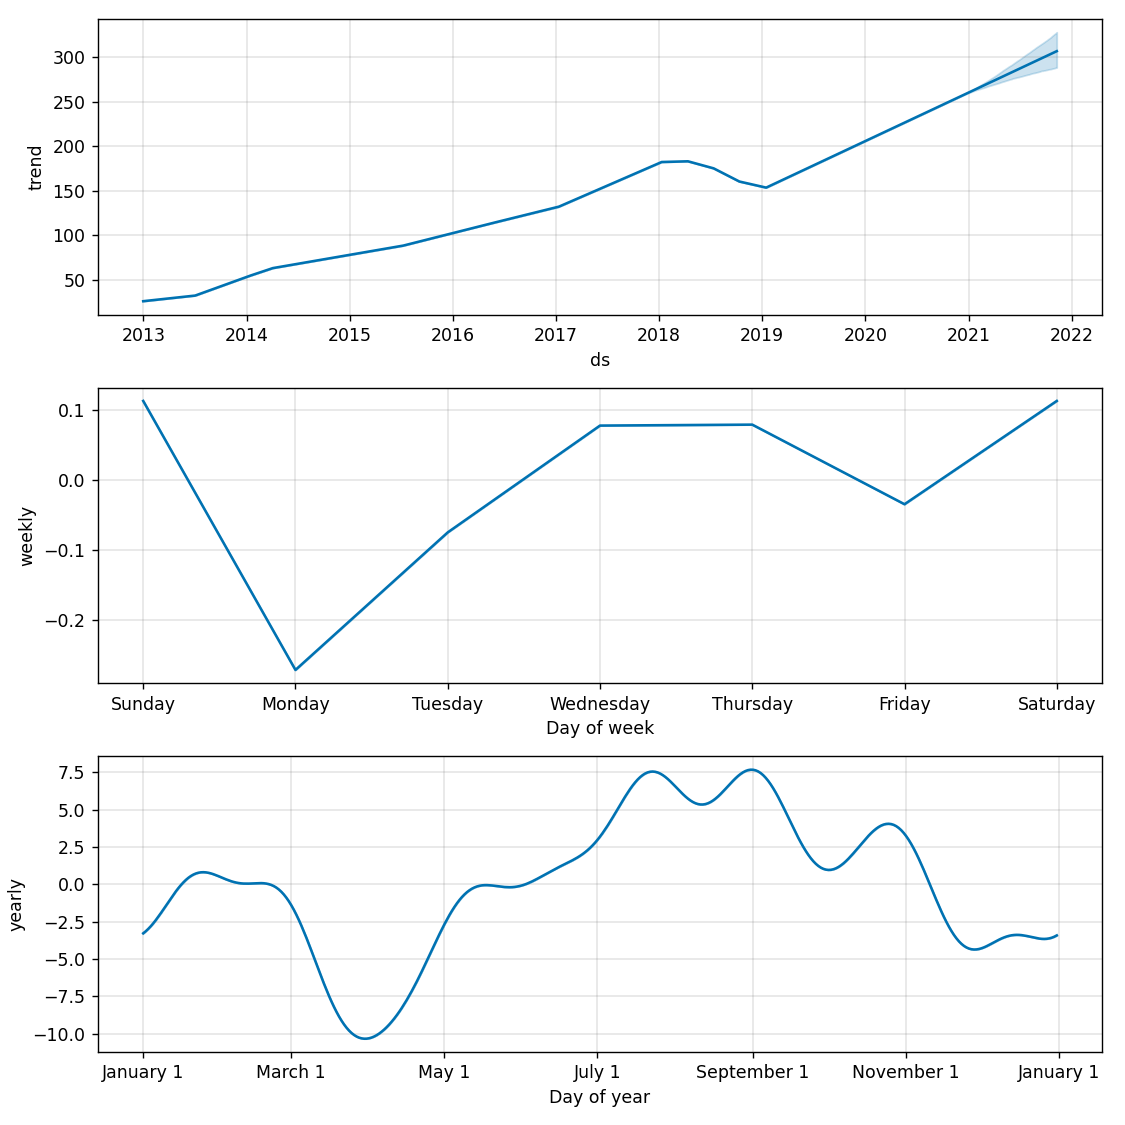

In [10]:
m.plot_components(forecast)
plt.show()


Based on the estimated trends, we can see that the stock price is usually maximum from mid of July to September. The first subplot shows the trend, showing an increase in the stock price in the future. This information should be useful for statistical analysis of price movements.

## Summary

This article provides you a sample of the Jupyter notebook to demonstrate how to use RDP Library for Python to retrieve the intraday daily price from the RDP Historical Pricing services. And it also uses the time series data with the Facebook prophet library for producing quick, accurate forecasts. It has intuitive parameters that can be fine-tuned by someone who has good domain knowledge but lacks technical skills in forecasting models.  We use the get_historical_price_summaries method from the RDP library to retrieve the daily prices for Facebook RIC FB.O and then pass the data to the prophet to forecast the next price 365 days. The library generates a chart to visualize predicted prices with the confidence intervals value. Prophet can provide seasonal charts such as a price trend and weekly, daily, and yearly trends depending on the parameters you pass to the function. The result from the forecasting will be additional input for stock price technical analysis. RDP users can benefit from the content provided by another service as well. They can combine the predicted data with the News content from the News service etc. You can also use the data from RDP Historical Pricing with another 3rd party library or use it with your own algorithm to do other projects. It depends on your requirements.

## References

* [Refinitiv Data Platform APIs](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis)
* [Getting Started with RDP Library for Python](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/quick-start)
* [RDP Library Python Example on Github](https://github.com/Refinitiv-API-Samples/Example.RDPLibrary.Python)
* [Facebook Prophet Quickstart](https://facebook.github.io/prophet/docs/quick_start.html)
  